In [1]:
import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline

from pclib.nn.models import PCLinearClassifier
from pclib.nn.layers import PrecisionWeighted
from pclib.optim.train import train
from pclib.utils.plot import plot_stats
from pclib.optim.eval import track_vfe, accuracy
from customdataset import PreloadedDataset

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
# transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),                                
# ])

class TanhTransform(object):
    def __init__(self, a=1., b=0., c=1.0):
        self.a = a
        self.b = b
        self.c = c

    def __call__(self, img):
        return ((img * self.a).tanh() + self.b) * self.c

class InvTanhTransform(object):
    def __call__(self, img):
        num = 1 + img
        div = (1 - img).clamp(min=1e-6)
        m = 0.5 * torch.log(num / div)
        return m

class SigmoidTransform(object):
    def __call__(self, img):
        return img.sigmoid()
    
class ReLUTanhTransform(object):
    def __call__(self, img):
        return F.relu(img.tanh())


transform = transforms.Compose([
    transforms.ToTensor(),
    # InvTanhTransform(),
    transforms.Normalize((0.1307,), (0.3081,)),
    # SigmoidTransform(),
    # TanhTransform(a=2.0),
    # TanhTransform(a=1.0, b=1.0, c=0.5),
])

dataset = datasets.MNIST('../Datasets/', train=True, download=False, transform=transforms.ToTensor())
# # shorten dataset
# length = 1000
# dataset = torch.utils.data.Subset(dataset, range(length))

VAL_RATIO = 0.2
val_len = int(len(dataset) * VAL_RATIO)
train_len = len(dataset) - val_len
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_len, val_len])
train_dataset = PreloadedDataset.from_dataset(train_dataset, transform, device)
val_dataset = PreloadedDataset.from_dataset(val_dataset, transform, device)
INPUT_SHAPE = 784
NUM_CLASSES = 10

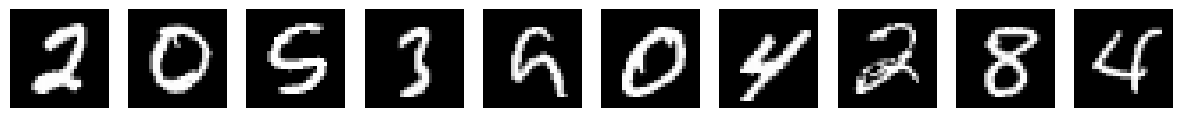

Max value:  tensor(2.8215, device='cuda:0')
Min value:  tensor(-0.4242, device='cuda:0')


In [4]:
# Show some images
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i, ax in enumerate(axes):
    img, label = train_dataset[i]
    ax.imshow(img.squeeze().cpu(), cmap='gray')
    ax.axis('off')
plt.show()

# print max min values
print('Max value: ', train_dataset.transformed_images.max())
print('Min value: ', train_dataset.transformed_images.min())

In [5]:
seed = 42
torch.manual_seed(seed)

num_models = 1
models = [PCLinearClassifier(
    input_size=INPUT_SHAPE, 
    num_classes=NUM_CLASSES, 
    hidden_sizes=[2000, 2000, 2000],
    bias=True, 
    symmetric=True, 
    actv_fn=F.relu,
    steps=50,
    gamma=0.1,
    beta=1.0,
    ).to(device) for _ in range(num_models)]
step = [0 for _ in range(num_models)]
stats = [None for _ in range(num_models)]

In [6]:
# Train Loop
LEARNING_RATE = 3e-4
NUM_EPOCHS = 20
BATCH_SIZE = 1000
REG_COEFF = 1e-2

for i, model in enumerate(models):
    step[i], stats[i] = train(
        model, 
        train_dataset, 
        val_dataset, 
        NUM_EPOCHS, 
        LEARNING_RATE, 
        batch_size=BATCH_SIZE,
        reg_coeff=REG_COEFF,
        step=step[i], 
        init_mode='randn',
        stats=stats[i],
        device=device,
        optim='AdamW',
    )

plot_stats(stats[-1], models[-1])

KeyboardInterrupt: 

In [7]:
train_vfes = torch.tensor([stats[i]['train_vfe'][-1] for i in range(num_models)])
val_vfes = torch.tensor([stats[i]['val_vfe'][-1] for i in range(num_models)])
val_accs = torch.tensor([stats[i]['val_acc'][-1] for i in range(num_models)])

# Show statistics across models, std is nan if num_models = 1
print(f"Tra VFE - mean: {train_vfes.mean():.3f} | std: {train_vfes.std():.3f} | min: {train_vfes.min():.3f} | max: {train_vfes.max():.3f}")
print(f"Val VFE - mean: {val_vfes.mean():.3f} | std: {val_vfes.std():.3f} | min: {val_vfes.min():.3f} | max: {val_vfes.max():.3f}")
print(f"Val Acc - mean: {val_accs.mean():.3f} | std: {val_accs.std():.3f} | min: {val_accs.min():.3f} | max: {val_accs.max():.3f}")

Tra VFE - mean: 85.680 | std: nan | min: 85.680 | max: 85.680
Val VFE - mean: 82.875 | std: nan | min: 82.875 | max: 82.875
Val Acc - mean: 0.820 | std: nan | min: 0.820 | max: 0.820


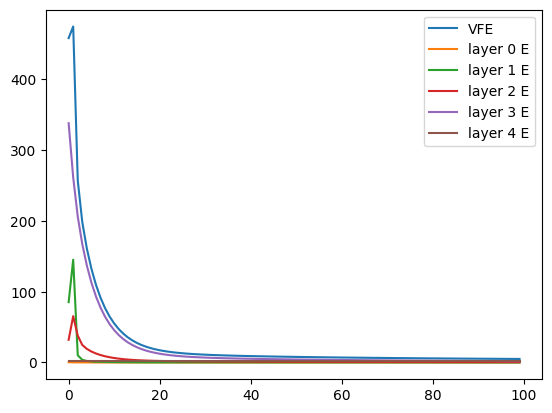

In [11]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=False)
images, y = next(iter(train_loader))
x = images.view(images.shape[0], -1)
y = torch.nn.functional.one_hot(y, NUM_CLASSES).float()
track_vfe(models[0], x, steps=100, plot_Es=True)

Max accuracy: 0.9784166666666667


0.9784166666666667

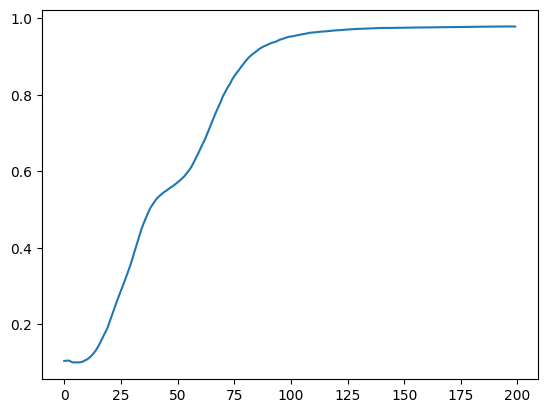

In [12]:
# Plots accuracy of the model as it converges
accuracy(model, val_dataset, steps=200)

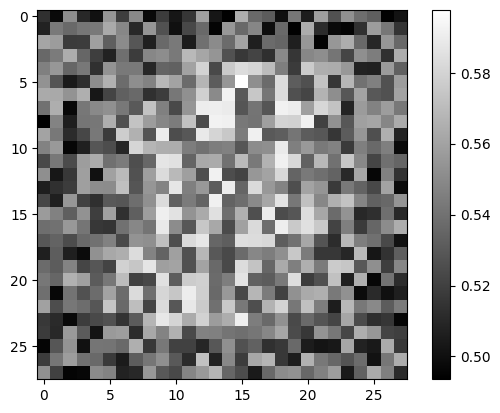

(0.49357632, 0.59777606)

In [8]:
assert isinstance(models[0].layers[0], PrecisionWeighted), "This cell only works for PrecisionWeighted layers"
# show diag of weight_var matrix as 28x28 image for layer 0
model = models[0]
layer = 0
weight_var = model.layers[0].weight_var.diag().view(28,28).detach().cpu().numpy()
# weight_var = model.layers[0].weight_var.detach().cpu().numpy()
plt.imshow(weight_var, cmap='gray')
plt.colorbar()
plt.show()
weight_var.min(), weight_var.max()
